In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
df = pd.read_csv('/kaggle/input/credit-card-behaviour-score/Dev_data_to_be_shared.csv')
val = pd.read_csv('/kaggle/input/credit-card-behaviour-score/validation_data_to_be_shared.csv')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df.shape

(96806, 1216)

In [3]:
## Dropping the account number column
df.drop(columns=['account_number'],inplace=True)
val.drop(columns=['account_number'],inplace=True)

In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [5]:
df.isnull().sum()

bad_flag                       0
onus_attribute_1           25231
transaction_attribute_1    25231
transaction_attribute_2    25231
transaction_attribute_3    25231
                           ...  
onus_attribute_44          85196
onus_attribute_45          85196
onus_attribute_46          85196
onus_attribute_47          85196
onus_attribute_48          85196
Length: 1215, dtype: int64

In [6]:
## Removing columns which has more than 20K null values
missing_values_count = df.isnull().sum()
columns_to_drop = missing_values_count[missing_values_count>20000].index
df = df.drop(columns=columns_to_drop)
val = val.drop(columns=columns_to_drop)

In [7]:
df.shape

(96806, 520)

In [8]:
## Distribution of class labels
df['bad_flag'].value_counts()

bad_flag
0    95434
1     1372
Name: count, dtype: int64

In [9]:
correlation = df.corr()

In [10]:
# Considering only top 30 features that correlates with target ('bad_flag')
target_correlation = correlation['bad_flag'].abs()
top_50_features = target_correlation.sort_values(ascending=False).head(51).index
df_filtered = df[top_50_features]

val_filtered = val[top_50_features[1:]]

In [11]:
df_filtered.head()

,bad_flag,onus_attribute_2,onus_attribute_17,onus_attribute_23,onus_attribute_20,onus_attribute_26,onus_attribute_32,onus_attribute_29,onus_attribute_33,onus_attribute_35,...,onus_attribute_24,onus_attribute_21,bureau_116,bureau_98,bureau_95,bureau_22,bureau_96,onus_attribute_36,onus_attribute_42,bureau_88
0,0,0.000000,0.000000,0.052730,0.052730,0,0,0,0,0,...,0,0,0.0,0.0,0.0,7.0,0.0,0,0,0.0
1,0,0.493875,0.353684,0.411915,0.411915,1,3,0,1,0,...,0,0,7.0,0.0,1.0,8.0,3.0,0,0,0.0
2,0,0.430024,0.362633,0.346129,0.346129,0,0,0,0,0,...,0,0,4.0,2.0,3.0,4.0,3.0,0,0,1.0
3,0,0.014543,0.064999,0.044924,0.044924,0,0,0,0,0,...,0,0,14.0,0.0,2.0,4.0,2.0,0,0,0.0
4,0,0.002247,0.000749,0.019984,0.019984,0,0,0,0,0,...,0,0,3.0,0.0,2.0,3.0,2.0,0,0,0.0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

X = df_filtered.drop(columns=['bad_flag'])
y = df_filtered['bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
## Replacing null values with column median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
val_imputed = imputer.transform(val_filtered)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
val_scaled = scaler.transform(val_imputed)

## XGBoost

Accuracy: 0.9669455634748476
Precision: 0.051470588235294115
Recall: 0.07664233576642336


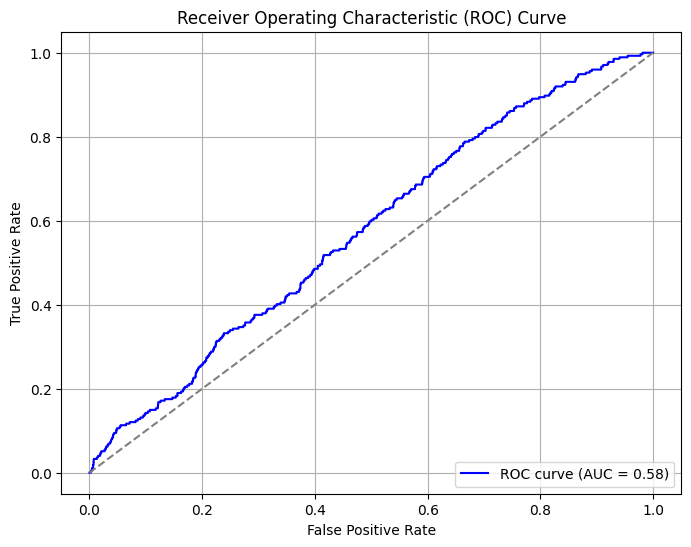

In [15]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

clf = xgb.XGBClassifier(scale_pos_weight=96.6/3.4)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))


#
y_probs = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Validation Data

In [16]:

y_pred = clf.predict(val_scaled)

In [17]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
y_proba = clf.predict_proba(val_scaled)
y_proba

array([[0.7838525 , 0.21614747],
       [0.9979797 , 0.00202032],
       [0.9927109 , 0.0072891 ],
       ...,
       [0.8126414 , 0.1873586 ],
       [0.9664048 , 0.0335952 ],
       [0.7196213 , 0.2803787 ]], dtype=float32)